<a href="https://colab.research.google.com/github/RayOfLight07/Deep-Learning/blob/main/DL_LAB_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep learning Lab_________________________________________________________________________Name: Deepasnhu Rathore     
B.Tech. 5th Sem.
#**Experiment:- 07**
# Implementing CNN: Convolution, Pooling, Feature Maps Visualization
Date:30\09\2025____________________________________________________________________________________SAP: 500124406

## **Aim and Objective**

**Aim:** To implement a CNN and visualize the intermediate feature maps generated by Convolutional and Pooling layers.

**Objective:**

*   To understand the mathematical operation of Convolution (Feature Extraction).
*   To observe the effect of Max Pooling (Downsampling/Dimensionality Reduction).
*   To interpret "Feature Maps" to see what the network is actually "seeing" (e.g., edges, textures).

## **Theory**

A CNN processes images through a series of layers. The output of each layer is called a Feature Map.

*   **Convolution:** Slides filters (kernels) over the input. Early layers usually detect simple features like vertical/horizontal edges or colors.

*   **ReLU Activation:** Removes negative values, effectively keeping only the "active" features (blacking out the rest).

*   **Max Pooling:** Looks at small windows (e.g., 2x2) and keeps only the maximum value. This makes the image smaller and pixelated but retains the most important information.

# **Runtime & GPU check**

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Imports, seed and helper functions**

In [3]:
import os
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(42)

# small helper to plot images in a grid
def show_images_grid(images, labels=None, preds=None, ncols=5, title=None):
    n = min(len(images), ncols * ((len(images)+ncols-1)//ncols))
    rows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(rows, ncols, figsize=(ncols*2, rows*2))
    axes = axes.flatten()
    for i in range(n):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        caption = ""
        if labels is not None: caption += f"GT:{labels[i]}"
        if preds is not None: caption += f" | P:{preds[i]}"
        ax.set_title(caption, fontsize=8)
        ax.axis('off')
    for j in range(n, len(axes)):
        axes[j].axis('off')
    if title: fig.suptitle(title)
    plt.show()


# **Load MNIST and preprocess**

In [4]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize and add channel dim
x_train = (x_train.astype("float32") / 255.0)[..., np.newaxis]   # shape (60000,28,28,1)
x_test  = (x_test.astype("float32")  / 255.0)[..., np.newaxis]

# one-hot labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat  = to_categorical(y_test, 10)

# create a validation split
val_split = 5000
x_val = x_train[-val_split:]
y_val_cat = y_train_cat[-val_split:]
x_train = x_train[:-val_split]
y_train_cat = y_train_cat[:-val_split]

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train_cat.shape, y_val_cat.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(55000, 28, 28, 1) (5000, 28, 28, 1) (10000, 28, 28, 1)
(55000, 10) (5000, 10)


# **Visualize some samples**

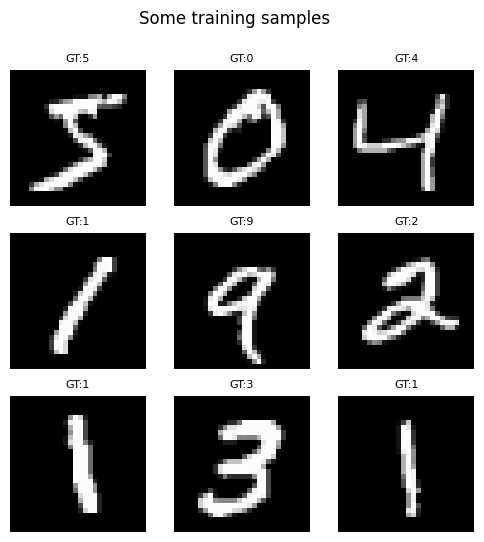

In [7]:
show_images_grid(x_train[:9], labels=y_train[:9], ncols=3, title="Some training samples")


# **Build the CNN model**

In [8]:
input_shape = (28,28,1)
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape, name='conv_1'),
    layers.BatchNormalization(name='bn_1'),
    layers.MaxPooling2D((2,2), name='pool_1'),

    layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv_2'),
    layers.BatchNormalization(name='bn_2'),
    layers.MaxPooling2D((2,2), name='pool_2'),

    layers.Conv2D(128, (3,3), activation='relu', padding='same', name='conv_3'),
    layers.BatchNormalization(name='bn_3'),
    # (optional) layers.MaxPooling2D((2,2), name='pool_3'),

    layers.Flatten(name='flatten'),
    layers.Dense(128, activation='relu', name='dense_1'),
    layers.Dropout(0.5, name='dropout'),
    layers.Dense(10, activation='softmax', name='predictions')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897,802 (3.42 MB)

 Trainable params: 897,354 (3.42 MB)

 Non-trainable params: 448 (1.75 KB)

# **Callbacks & Train**

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

history = model.fit(
    x_train, y_train_cat,
    validation_data=(x_val, y_val_cat),
    epochs=12,
    batch_size=128,
    callbacks=callbacks
)


Epoch 1/12
430/430 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.8730 - loss: 0.4327 - val_accuracy: 0.9276 - val_loss: 0.2756 - learning_rate: 0.0010
Epoch 2/12
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9751 - loss: 0.0849 - val_accuracy: 0.9864 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 3/12
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9842 - loss: 0.0565 - val_accuracy: 0.9906 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 4/12
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9882 - loss: 0.0417 - val_accuracy: 0.9904 - val_loss: 0.0545 - learning_rate: 0.0010
Epoch 5/12
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9901 - loss: 0.0341 - val_accuracy: 0.9860 - val_loss: 0.0875 - learning_rate: 0.0010
Epoch 6/12
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9932 - loss: 0.0219 - val_accuracy: 0.9942 - val_loss: 0.0300 - learning_rate: 5.0000e-04
Epoch 7/12
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9960 - loss: 0

# **Plot training curves**

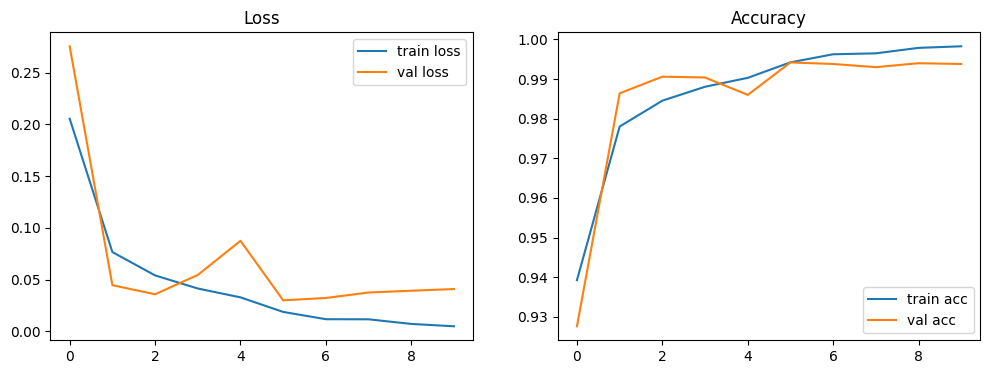

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()


## **Evaluate on test set and sample predictions**

Test loss: 0.020059192553162575 Test accuracy: 0.9944999814033508
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


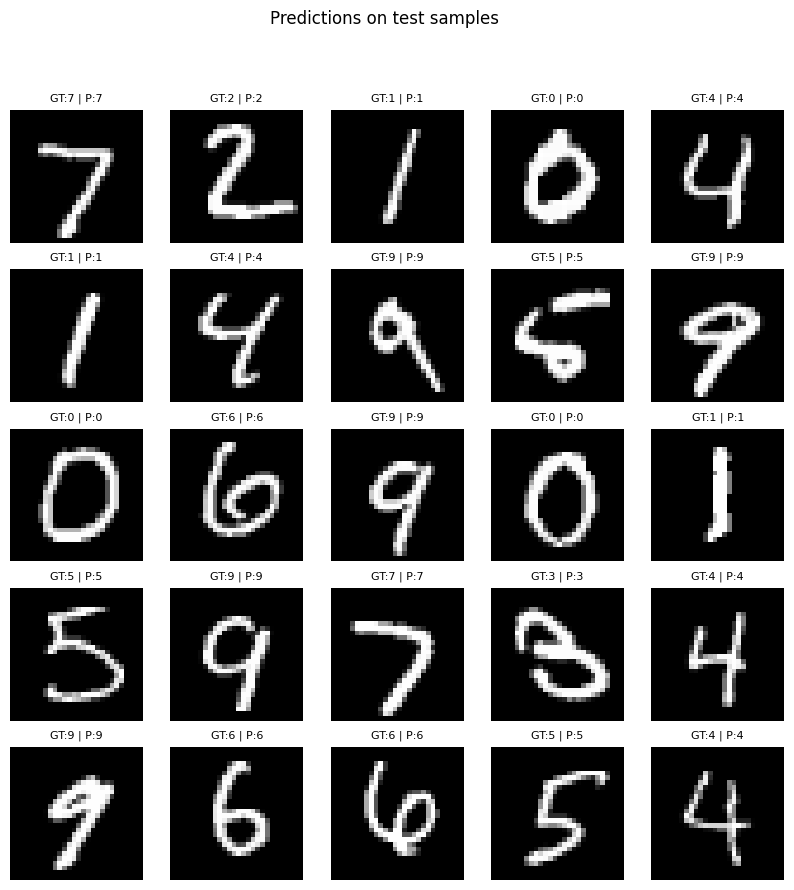

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print("Test loss:", test_loss, "Test accuracy:", test_acc)

# show some predictions
preds_prob = model.predict(x_test[:25])
preds = np.argmax(preds_prob, axis=1)
show_images_grid(x_test[:25], labels=y_test[:25], preds=preds, ncols=5, title="Predictions on test samples")


# **Confusion matrix & classification report**

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


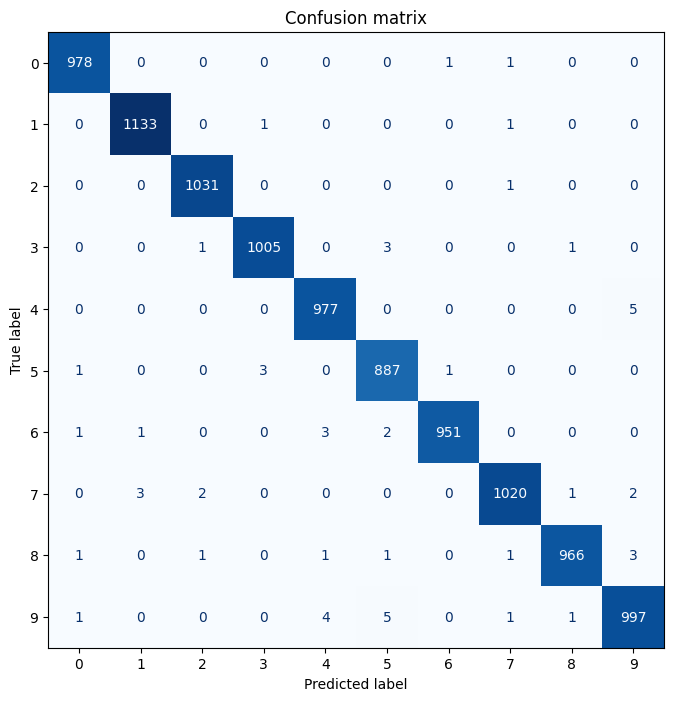

              precision    recall  f1-score   support

           0     0.9959    0.9980    0.9969       980
           1     0.9965    0.9982    0.9974      1135
           2     0.9961    0.9990    0.9976      1032
           3     0.9960    0.9950    0.9955      1010
           4     0.9919    0.9949    0.9934       982
           5     0.9878    0.9944    0.9911       892
           6     0.9979    0.9927    0.9953       958
           7     0.9951    0.9922    0.9937      1028
           8     0.9969    0.9918    0.9943       974
           9     0.9901    0.9881    0.9891      1009

    accuracy                         0.9945     10000
   macro avg     0.9944    0.9944    0.9944     10000
weighted avg     0.9945    0.9945    0.9945     10000



In [12]:

from sklearn.metrics import ConfusionMatrixDisplay
y_pred = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion matrix")
plt.show()

print(classification_report(y_test, y_pred, digits=4))


In [13]:
from tensorflow.keras import layers, models, Input

input_shape = (28, 28, 1)

# Functional API model
inputs = Input(shape=input_shape, name="input_layer")

x = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv_1')(inputs)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.MaxPooling2D((2,2), name='pool_1')(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.MaxPooling2D((2,2), name='pool_2')(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same', name='conv_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(128, activation='relu', name='dense_1')(x)
x = layers.Dropout(0.5, name='dropout')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = models.Model(inputs=inputs, outputs=outputs, name="mnist_cnn")

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "mnist_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897,802 (3.42 MB)

 Trainable params: 897,354 (3.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
from tensorflow.keras.models import Model

# Pick conv/pool layers to visualize
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]
layer_names   = [layer.name for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]

# Feature extractor model
feature_extractor = Model(inputs=model.input, outputs=layer_outputs)

print("Layers to visualize:", layer_names)


Layers to visualize: ['conv_1', 'pool_1', 'conv_2', 'pool_2', 'conv_3']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
Number of feature-map outputs: 5
0 conv_1 (1, 28, 28, 32)
1 pool_1 (1, 14, 14, 32)
2 conv_2 (1, 14, 14, 64)
3 pool_2 (1, 7, 7, 64)
4 conv_3 (1, 7, 7, 128)


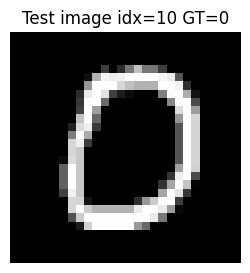

In [15]:
idx = 10                     # change this index to any test image
img = x_test[idx]            # shape (28,28,1)
plt.figure(figsize=(3,3)); plt.imshow(img.squeeze(), cmap='gray'); plt.title(f"Test image idx={idx} GT={y_test[idx]}"); plt.axis('off')

# get feature maps (list of arrays)
feature_maps = feature_extractor.predict(np.expand_dims(img, axis=0))
print("Number of feature-map outputs:", len(feature_maps))
# Each element: shape (1, H, W, channels)
for i, fmap in enumerate(feature_maps):
    print(i, layer_names[i], fmap.shape)


# **Function to nicely plot feature maps of one layerdef plot_feature_map_grid**

In [17]:
def plot_feature_map_grid(fmap, layer_name, max_cols=8):
    # fmap shape: (1, H, W, channels)
    fmap = np.squeeze(fmap)            # (H, W, channels)
    if fmap.ndim == 2:
        # single channel image
        plt.figure(figsize=(3,3))
        plt.imshow(fmap, cmap='gray')
        plt.title(layer_name)
        plt.axis('off')
        plt.show()
        return

    n_channels = fmap.shape[-1]
    cols = min(max_cols, n_channels)
    rows = n_channels // cols + (1 if n_channels % cols else 0)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    axes = axes.flatten()
    for i in range(rows*cols):
        ax = axes[i]
        if i < n_channels:
            # scale for display
            channel_img = fmap[:,:,i]
            channel_img -= channel_img.mean()
            if channel_img.std() != 0:
                channel_img /= (channel_img.std())
            channel_img *= 64
            channel_img += 128
            ax.imshow(channel_img.astype('uint8'), cmap='gray')
            ax.set_title(f"{i}")
        ax.axis('off')
    fig.suptitle(layer_name)
    plt.show()


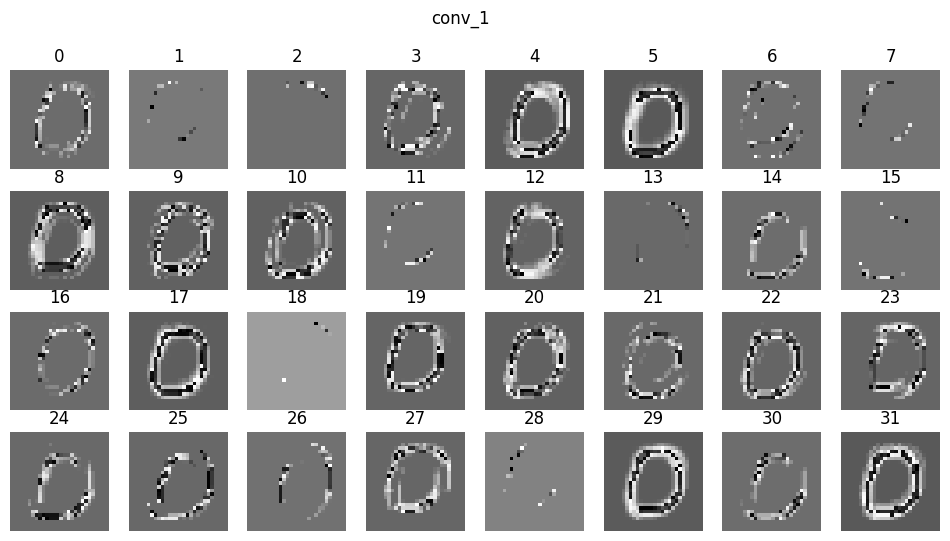

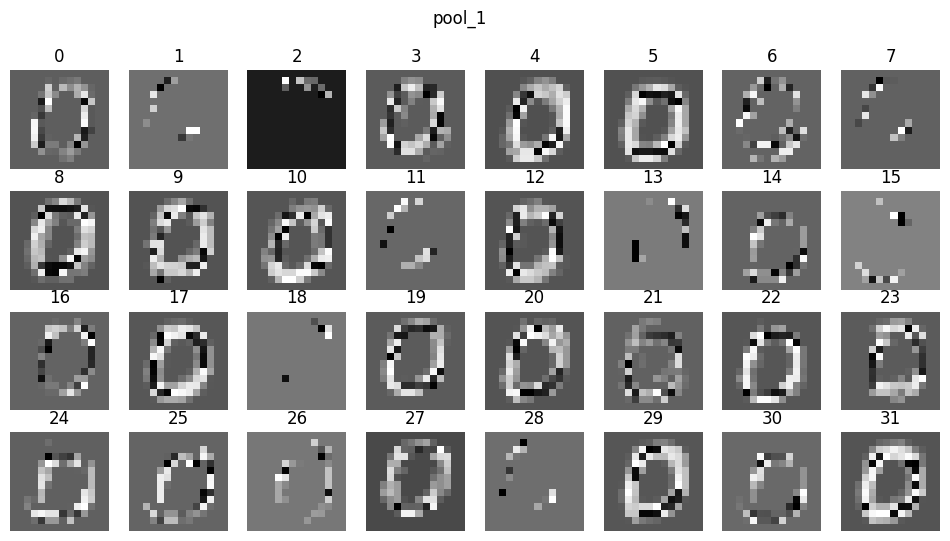

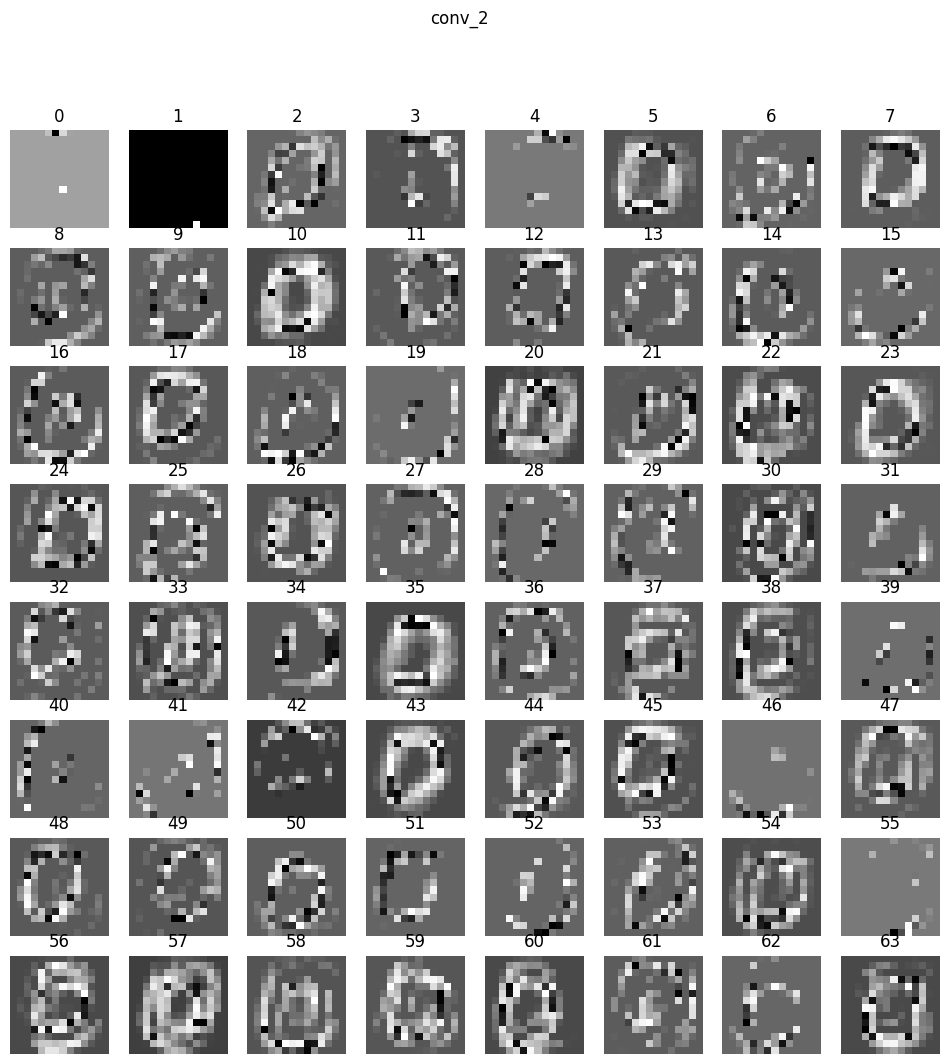

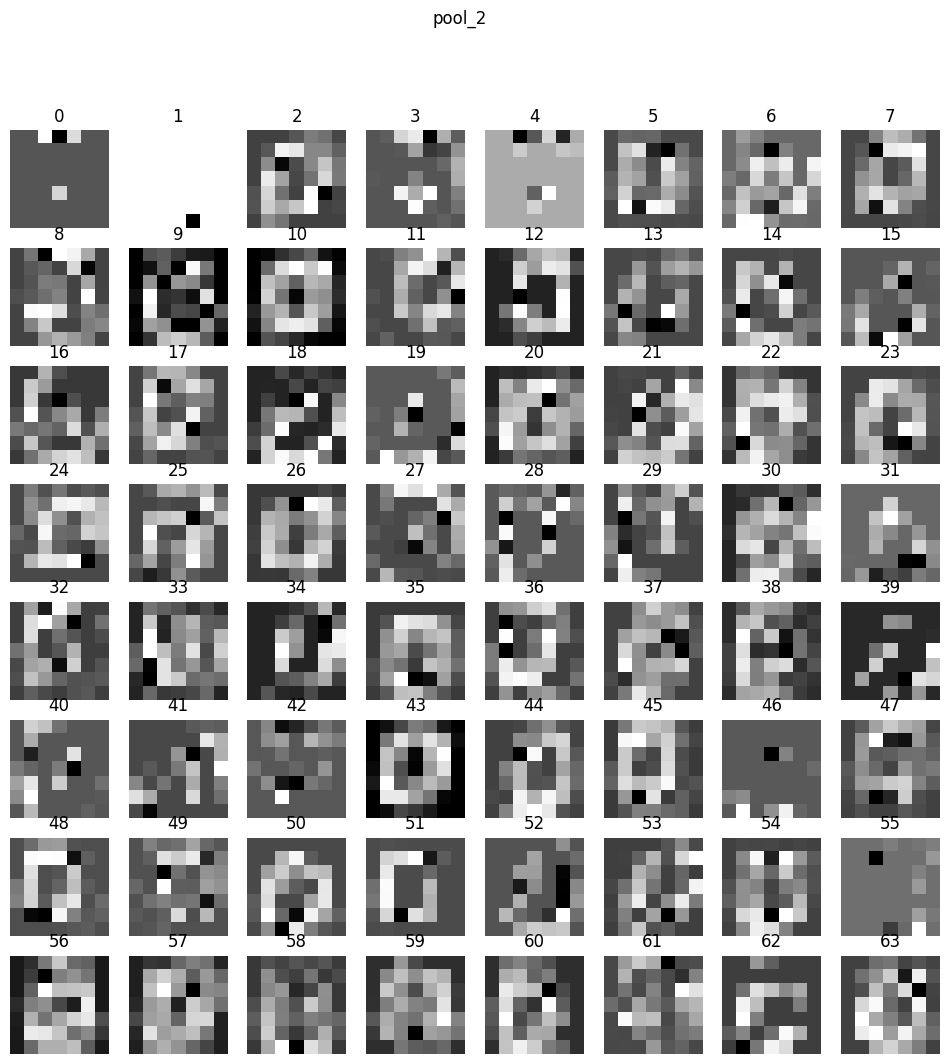

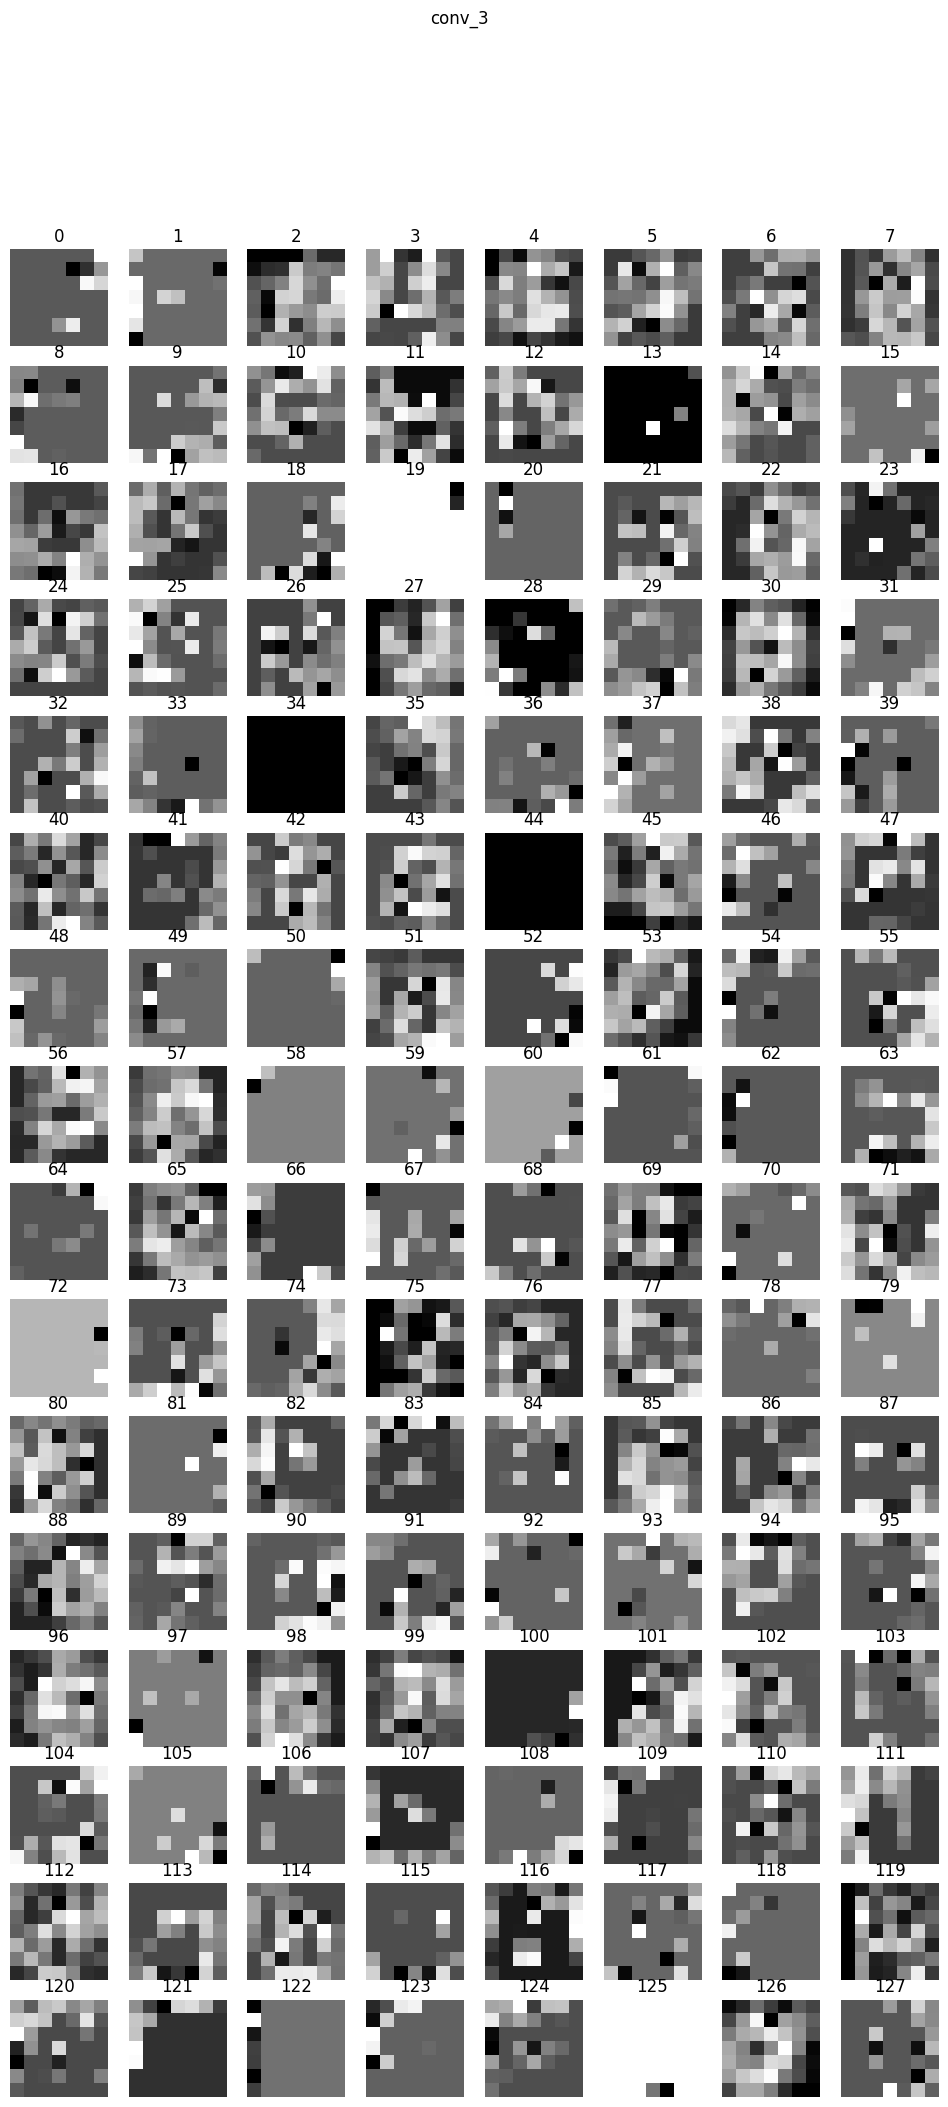

In [ ]:
# Cell 12 — Plot feature maps for all chosen layers for the selected image
for fmap, name in zip(feature_maps, layer_names):
    plot_feature_map_grid(fmap, name, max_cols=8)


filters shape: (3, 3, 1, 32)


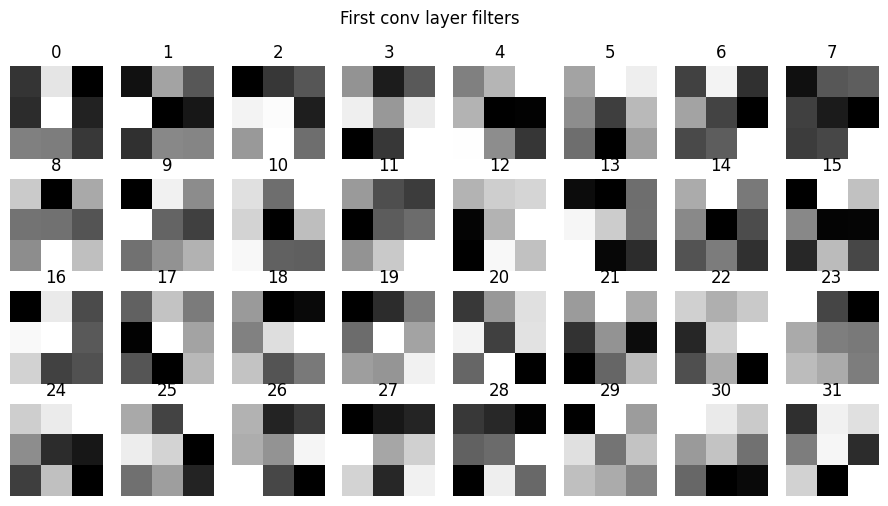

In [ ]:
# Cell 13 — Get weights of the very first conv layer and display the filters
first_conv = model.get_layer('conv_1')
filters, biases = first_conv.get_weights()    # filters shape: (kernel_h, kernel_w, in_ch, out_ch)
print("filters shape:", filters.shape)

# normalize and plot filters (we have 32 filters)
n_filters = filters.shape[-1]
fig_cols = 8
fig_rows = int(np.ceil(n_filters / fig_cols))
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(fig_cols*1.4, fig_rows*1.4))
axes = axes.flatten()
for i in range(fig_rows*fig_cols):
    ax = axes[i]
    if i < n_filters:
        f = filters[:, :, 0, i]   # single-channel input
        # normalize for display
        fmin, fmax = f.min(), f.max()
        f_img = (f - fmin) / (fmax - fmin + 1e-8)
        ax.imshow(f_img, cmap='gray', interpolation='nearest')
        ax.set_title(str(i))
    ax.axis('off')
plt.suptitle("First conv layer filters")
plt.show()


Saving sample_image.png to sample_image.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


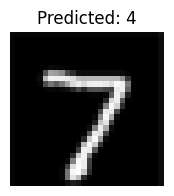

In [ ]:
from google.colab
import filesfrom PIL import Image
uploaded = files.upload()   # choose your image file

for filename in uploaded.keys():
    img = Image.open(filename).convert('L')  # grayscale
    img = img.resize((28,28))
    arr = np.array(img).astype('float32') / 255.0
    arr = arr[..., np.newaxis]
    pred = np.argmax(model.predict(arr[np.newaxis,...]), axis=1)[0]
    plt.figure(figsize=(2,2)); plt.imshow(arr.squeeze(), cmap='gray'); plt.title(f"Predicted: {pred}"); plt.axis('off')
    plt.show()


In [ ]:
model.save('mnist_cnn.h5')
try:
    from google.colab import files
    files.download('mnist_cnn.h5')
except:
    print("Saved to mnist_cnn.h5 in the notebook workspace.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Observations and Conclusion**

**Observations:**

*   **Convolution Layer:** The visualized feature maps look like "ghostly" versions of the original image. Some filters highlight only the vertical edges (like the bird's legs), while others highlight horizontal edges or texture. The image size remains large (224x224).

*   **Pooling Layer:** The feature maps look blockier and more pixelated. The size has reduced by half (112x112). However, the important features (the shape of the bird) are still clearly visible, just compressed.

**Conclusion:**

*   We successfully visualized the internal workings of a CNN.

*   We confirmed that Convolution acts as a feature extractor (finding edges) and Pooling acts as a compressor (keeping distinct features while removing unnecessary detail).